In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
poi_metrics = pd.read_csv('hitting_poi_metrics.csv')
joint_angles = pd.read_csv('hitting_joint_angles.csv')

In [2]:
#Plots the data with +- 1SD
# Define Bat Speed Groups (Above 70MPH and lower than 68MPH)
poi_metrics['Bat_Speed_Group'] = np.where(
    poi_metrics['blast_bat_speed_mph_x'] > 70, 'High', 
    np.where(poi_metrics['blast_bat_speed_mph_x'] < 68, 'Low', 'Exclude')
)
# Exclude swings in the middle
poi_metrics_filtered = poi_metrics[poi_metrics['Bat_Speed_Group'] != 'Exclude']

In [3]:
# Merge Datasets on Player
merged_data = pd.merge(joint_angles, poi_metrics_filtered[['session_swing', 'Bat_Speed_Group']], on='session_swing', how='inner')

In [4]:
# Normalize Time Series Data(Resample to 100 Points)
normalized_data = []

for (player, group), data in merged_data.groupby(['session_swing', 'Bat_Speed_Group']):
    # Sort by time to ensure consistency
    data = data.sort_values(by='time')
    # Interpolation to 100 points
    time_normalized = np.linspace(data['time'].min(), data['time'].max(), 100)
    hip_torso_interp = np.interp(time_normalized, data['time'], data['torso_pelvis_angle_y'])
    normalized_data.append(pd.DataFrame({
        'Player': player,
        'Bat_Speed_Group': group,
        'Time_Normalized': range(1, 101),
        'torso_pelvis_angle_y': hip_torso_interp
    }))

normalized_df = pd.concat(normalized_data, ignore_index=True)

In [5]:
# Calculate Mean and Standard Deviation for Each Group
group_stats = normalized_df.groupby(['Bat_Speed_Group', 'Time_Normalized'])['torso_pelvis_angle_y'].agg(
    Mean='mean',
    Std='std'
).reset_index()

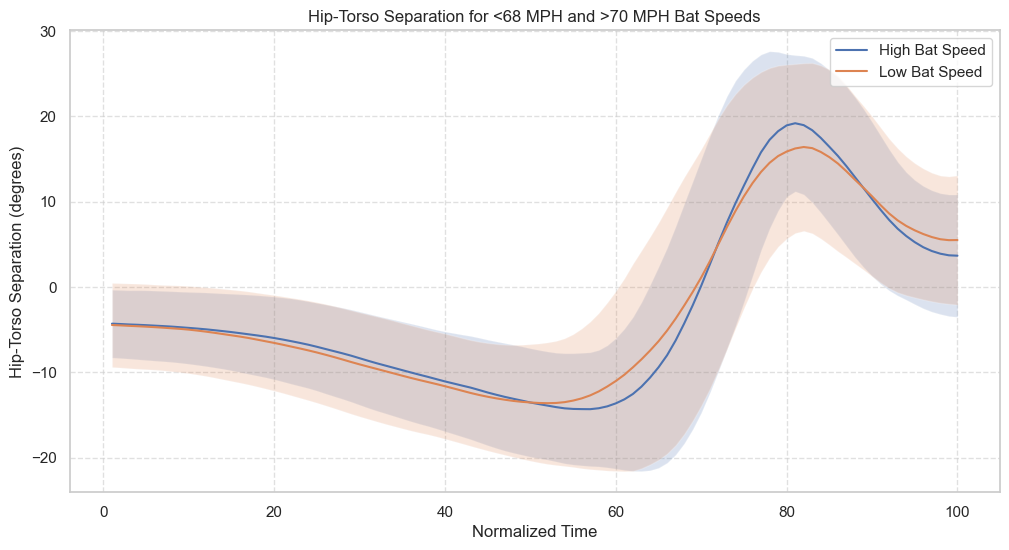

In [6]:
# Plot the groups and Standard Deviation
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

for group, group_data in group_stats.groupby('Bat_Speed_Group'):
    plt.plot(group_data['Time_Normalized'], group_data['Mean'], label=f'{group} Bat Speed')
    plt.fill_between(
        group_data['Time_Normalized'],
        group_data['Mean'] - group_data['Std'],
        group_data['Mean'] + group_data['Std'],
        alpha=0.2
    )

plt.title('Hip-Torso Separation for <68 MPH and >70 MPH Bat Speeds')
plt.xlabel('Normalized Time')
plt.ylabel('Hip-Torso Separation (degrees)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

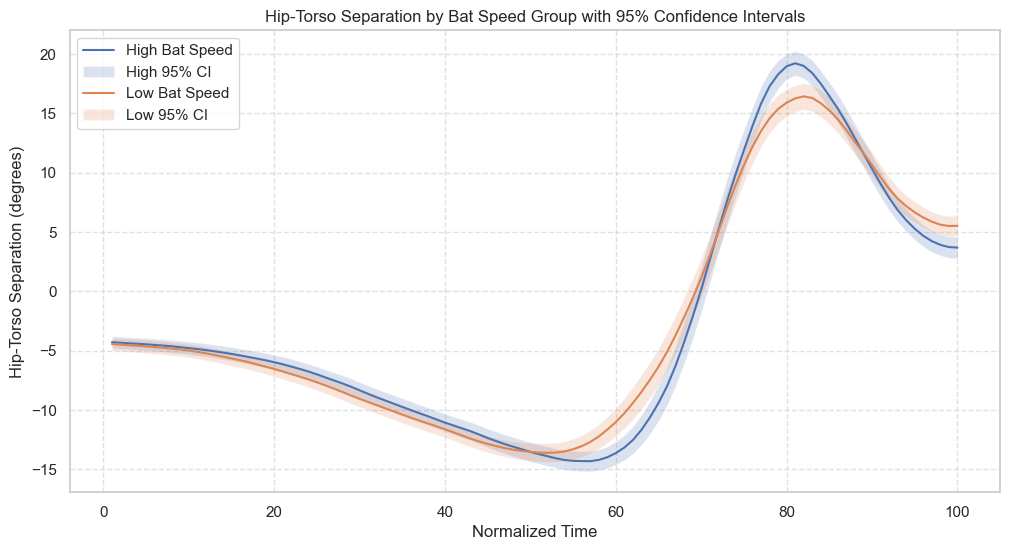

In [7]:
# Graphs the data with 95% Confidence Intervals

from scipy.stats import sem, t

# Calculate 95% Confidence Intervals
ci_data = []

# Group by Bat_Speed_Group and Time_Normalized to calculate CI
for (group, time_point), group_data in normalized_df.groupby(['Bat_Speed_Group', 'Time_Normalized']):
    # Get the mean and standard error
    mean = group_data['torso_pelvis_angle_y'].mean()
    std_err = sem(group_data['torso_pelvis_angle_y'], nan_policy='omit')  # Standard error of the mean
    
    # Calculate the confidence interval
    n = len(group_data['torso_pelvis_angle_y'].dropna())  # Sample size
    ci_range = t.ppf(0.975, n-1) * std_err  # 95% CI
    
    # Store results
    ci_data.append({
        'Bat_Speed_Group': group,
        'Time_Normalized': time_point,
        'Mean': mean,
        'CI_Lower': mean - ci_range,
        'CI_Upper': mean + ci_range
    })

# Convert CI data to DataFrame
ci_df = pd.DataFrame(ci_data)

# Plot with Confidence Intervals
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Loop through each group to plot the mean and CI
for group, group_data in ci_df.groupby('Bat_Speed_Group'):
    plt.plot(group_data['Time_Normalized'], group_data['Mean'], label=f'{group} Bat Speed')
    plt.fill_between(
        group_data['Time_Normalized'],
        group_data['CI_Lower'],
        group_data['CI_Upper'],
        alpha=0.2,
        label=f'{group} 95% CI'
    )

# Customize plot
plt.title('Hip-Torso Separation by Bat Speed Group with 95% Confidence Intervals')
plt.xlabel('Normalized Time')
plt.ylabel('Hip-Torso Separation (degrees)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()